# Lista 3 Zuzanna Sosnowska

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import copy
import time
from typing import Iterable

In [3]:
# Wykorzystywane klasy
class Vector(Iterable):
    def __init__(self, elems=None):
        if elems is None:
            elems = []
        self.__elems = elems

    def __getitem__(self, key):
        return self.__elems[key]

    def __setitem__(self, key, val):
        self.__elems[key] = val

    def __len__(self):
        return len(self.__elems)

    def __iter__(self):
        return self.__elems.__iter__()

    def __add__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a + b for a, b in zip(self, other)])

    def __neg__(self):
        return Vector([-a for a in self.__elems])

    def __sub__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a - b for a, b in zip(self, other)])

    def __mul__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a * b for a, b in zip(self, other)])

    def __rmul__(self, other):
        return Vector([other * a for a in self.__elems])

    def __str__(self):
        comma_list = ''.join([str(a) + ', ' for a in self.__elems])
        return '<' + comma_list[:-2] + '>'

    def copy(self):
        return Vector([*self.__elems])

    def append(self, val):
        self.__elems.append(val)

    def norm(self):
        return sum(map(lambda x: abs(x), self.__elems))
    
    def norm_inf(self):
        return max(map(lambda x: abs(x), self.__elems))
class Matrix:

    def __init__(self):
        self.__rows = []

    @staticmethod
    def from_vectors(vectors):
        m = Matrix()
        for vec in vectors:
            m.add_row(vec)
        return m

    @staticmethod
    def create_from_list(list_of_lists):
        m = Matrix()
        for row in list_of_lists:
            m.add_row(Vector(row))
        return m

    @staticmethod
    def identity_matrix(n):
        I = [[1 if i == j  else 0 for i in range(n)] for j in range(n)]
        return Matrix.create_from_list(I)

    def number_of_rows(self):
        return len(self.__rows)

    def number_of_columns(self):
        return 0 if len(self.__rows) == 0 else len(self.__rows[0])

    def is_empty(self):
        return len(self.__rows) == 0

    def __len__(self):
        return self.number_of_rows() * self.number_of_columns()

    def __getitem__(self, item):
        return self.__rows[item]

    def __setitem__(self, key, new_row):
        self.__rows[key] = new_row

    def __str__(self):
        return ''.join([str(row) + '\n' for row in self.__rows])

    def __rmul__(self, other):
        return Matrix.create_from_list([other * row for row in self.__rows])

    def __sub__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] -= other[i]

        return res
    
    def __add__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] += other[i]

        return res

    def copy(self):
        return Matrix.from_vectors([row.copy() for row in self.__rows])

    def add_row(self, new_row):
        if len(new_row) != self.number_of_columns() and not self.is_empty():
            raise ValueError("Matrix rows must be of equal length")
        self.__rows.append(new_row)

    def add_column(self, new_column):
        if len(new_column) != self.number_of_rows():
            raise ValueError("Matrix columns must be of equal length")
        for i in range(self.number_of_rows()):
            self.__rows[i].append(new_column[i])

    def subtract_rows(self, row1, row2):
        self.__rows[row1] -= self.__rows[row2]

    def multiply_row(self, key, scalar):
        self.__rows[key] *= scalar

    def swap_rows(self, row1, row2):
        self.__rows[row1], self.__rows[row2] = self.__rows[row2], self.__rows[row1]

    def multiply_column(self, column, scalar):
        for row in self.__rows:
            row[column] *= scalar

    def subtract_column(self, index1, index2):
        for row in self.__rows:
            row[index1] -= row[index2]

    def upper_triangular_matrix(self):
        matrix = copy.deepcopy(self)
        if matrix.number_of_rows() == matrix.number_of_columns():
            for j in range(matrix.number_of_columns()):
                find_nullifying_row = False
                for i in range(j, matrix.number_of_rows()):
                    if matrix[i][j] != 0 and find_nullifying_row == False:
                        matrix.swap_rows(i, j)
                        find_nullifying_row = True
                        continue
                    if find_nullifying_row:
                        a = matrix[i][j] / matrix[j][j]
                        matrix[i] = matrix[i] - a * matrix[j]
                if not find_nullifying_row:
                    raise ValueError("Macierz osobliwa")
        return matrix

    def det(self):
        matrix = self.upper_triangular_matrix()
        det = 1
        for i in range(len(self.__rows)):
            det *= matrix[i][i]
        return det

    def multiply_matrix_by_vector(self, vector: Vector) -> Vector:
        if self.number_of_columns() != len(vector):
            raise ValueError("Vector length must be of equal to number of columns in matrix")
        new_vector = Vector()
        for row in self.__rows:
            new_vector.append(sum(row * vector))
        return new_vector

    def inv(self):
        if self.number_of_rows() != self.number_of_columns():
            raise ValueError("Matrix must be of equal length")
        matrix = copy.deepcopy(self)
        n = matrix.number_of_rows()
        I = Matrix.identity_matrix(n)
        for column in range(n):
            find_nullifying_row = False
            for row in range(column, n):
                if matrix[row][column] != 0 and find_nullifying_row == False:
                    matrix.swap_rows(row, column)
                    I.swap_rows(row, column)
                    find_nullifying_row = True
                    continue
                if find_nullifying_row:
                    modifier = matrix[row][column] / matrix[column][column]
                    matrix[row] = matrix[row] - modifier * matrix[column]
                    I[row] = I[row] - modifier * I[column]
            if not find_nullifying_row:
                raise ValueError("Macierz osobliwa")
        for column in range(n - 1, -1, -1):
            for row in range(column):
                modifier = matrix[row][column] / matrix[column][column]
                matrix[row] = matrix[row] - modifier * matrix[column]
                I[row] = I[row] - modifier * I[column]
            modifier = 1 / matrix[column][column]
            I[column] = modifier * I[column]
            matrix[column] = modifier * matrix[column]
        return I

    def norm(self):
        max = 0
        for row in self.__rows:
            if row.norm() > max:
                max = row.norm()
        return max

### Zadanie 1
Celem zadania jest rozwiązanie układu równań $Ax=b$, gdzie $A$ jest macierzą Hilberta o wymiarach $5×5$, a $b = (5, 4, 3, 2, 1)^T$, z wykorzystaniem metody iteracyjnego poprawiania rozwiązań, operując na danych w pojedynczej precyzji. W ramach tego zadania dąży się do zbadania skuteczności metody iteracyjnego poprawiania przy pracy na macierzach szczególnie wrażliwych na błędy numeryczne, takich jak macierz Hilberta.

In [10]:
def hilbert_matrix(n:int)->np.ndarray:
    return np.array([[1 / (i+j-1) for i in range(1, n+1)] for j in range(1, n+1)])


def norm(x):
    return np.max(np.abs(x))


def iter_correcting_solution(A:np.ndarray, b:np.ndarray, iter:int=10000) -> np.ndarray:
    A = np.copy(A).astype(np.float32)
    b = np.copy(b).astype(np.float32)
    n = len(A)
    A_inv = np.linalg.inv(A)
    x = A_inv @ b
    for i in range(iter):
        r = b - A @ x
        x += A_inv @ r
    return x


In [11]:
n = 5
A = hilbert_matrix(n)
b = np.array([5-i for i in range(n)])
x1 = iter_correcting_solution(A, b, iter=0)
x2 = iter_correcting_solution(A, b, iter=500)
x_np_float32 = np.linalg.solve(A.astype(np.float32), b.astype(np.float32))
x_sp_float32 = scipy.linalg.solve(A.astype(np.float32), b.astype(np.float32))
x_np = np.linalg.solve(A, b)
x_sp = scipy.linalg.solve(A, b)
print("Rozwiązanie równania bez iteracyjnego poprawiania rozwiązania:", '\n', x1)
print("Rozwiązanie równania za pomocą metody iteracyjnego poprawiania rozwiązania:",'\n',x2)
print("Rozwiązanie równania za pomocą pakietu numpy (w pojedynczej precyzji):",'\n',x_np_float32)
print("Rozwiązanie równania za pomocą pakietu scipy (w pojedynczej precyzji):",'\n',x_sp_float32)
print("Rozwiązanie równania za pomocą pakietu numpy:",'\n',x_np)
print("Rozwiązanie równania za pomocą pakietu scipy:",'\n', x_sp)

Rozwiązanie równania bez iteracyjnego poprawiania rozwiązania: 
 [   -94.84766   2157.1025  -10697.324    17900.664    -9440.457  ]
Rozwiązanie równania za pomocą metody iteracyjnego poprawiania rozwiązania: 
 [   -94.87814   2157.6448  -10699.628    17904.111    -9442.146  ]
Rozwiązanie równania za pomocą pakietu numpy (w pojedynczej precyzji): 
 [   -94.84782   2157.1013  -10697.322    17900.658    -9440.465  ]
Rozwiązanie równania za pomocą pakietu scipy (w pojedynczej precyzji): 
 [   -94.6073   2152.4734 -10677.024   17869.67    -9425.192 ]
Rozwiązanie równania za pomocą pakietu numpy: 
 [   -95.           2160.00000002 -10710.00000008  17920.00000012
  -9450.00000006]
Rozwiązanie równania za pomocą pakietu scipy: 
 [   -95.           2160.00000002 -10710.00000008  17920.00000012
  -9450.00000006]


Jak widać, metoda iteracyjnego poprawiania rozwiązania zwiększyła dokładność wyniku, jednak nadal pozostaje on niedokładny. Dla obliczeń z użyciem pojedynczej precyzji metoda ta wypada lepiej niż funkcje z bbibliotek. Niemniej jednak, podwójna precyzja – niezależnie od zastosowanej metody – zapewnia wyraźnie bardziej niezawodne wyniki.

### Zadanie 2

In [165]:
def create_matrix_to_ex_2(n:int)->Matrix:
    A = Matrix.identity_matrix(n)
    A = 4 * A
    for i in range(1, n):
        A[i][i-1] = -1
        A[i-1][i] = -1
    A[n-1][0] = 1
    A[0][n-1] = 1
    return A


def create_vector_to_ex_2(n:int)->Vector:
   return Vector([0 for i in range(n-1)] + [100])


def decompose_matrix(A:Matrix)->(Matrix, Matrix, Matrix):
    """
    Funkcja zwraca rozkład macierzy A dany wzorem: A = D + L + U, gdzie macierz D to macierz diagonalna, a
    macierze L i U to macierze górno i dolno trójkątne (tzn. L oraz U mają zera na głównej przekątnej).
    :param A: Macierz A
    :return: Funkcja zwraca kolejno macierz D, L i U
    """
    D = Matrix.create_from_list(np.zeros_like(A))
    L = Matrix.create_from_list(np.zeros_like(A))
    U = Matrix.create_from_list(np.zeros_like(A))

    for i in range(A.number_of_columns()):
        for j in range(A.number_of_rows()):
            if i == j:
                D[i][j] = A[i][j]
            elif i > j:
                L[i][j] = A[i][j]
            elif i < j:
                U[i][j] = A[i][j]

    return D, L, U


def gauss_seidle_method(A:Matrix, b:Vector, tol=1e-12, iter=100, showit=False)-> Vector:
    """
    Metoda rozwiązuje układ równań postaci b = Ax metodą Gaussa-Seidla.
    :param A: Macierz układu równań
    :param b: Wektor układu równań
    :param iter: Maksymalna liczba iteracji
    :param tol: Dokładność rozwiązania. Im mniejsza wartość parametru tol, tym większa dokładność rozwiązania
    :param showit: Jeśli wartość parametru wynosi True, to funkcja pokaże, ile iteracji potrzeba, aby uzyskac wynik
    :return: Funkcja zwraca wektor rozwiązań zadanego układu równań
    """
    D, L, U = decompose_matrix(A)
    n = A.number_of_rows()
    Q = inverse_lower_triangular_matrix(D + L)
    x = np.zeros(n)

    for it in range(iter):
        x_old = x.copy()
        x = Q.multiply_matrix_by_vector(b - U.multiply_matrix_by_vector(x))
        if (x - x_old).norm_inf() < tol:
            if showit:
                print(f"Zbieżność osiągnięta po {it + 1} iteracjach.", "\n")
            return x
    raise ValueError("Metoda Gaussa–Seidela nie osiągnęła zbieżności.")


def inverse_lower_triangular_matrix(A:Matrix)->Matrix:
    """
    Funkcja zwraca macierz odwrotną do macierzy dolnotrójkątnej (posiadającej elementy na głównej przekątnej)
    :param A: Macierz dolnotrójkątna A
    :return: Macierz odwrotna do macierzy A
    """
    B = A.copy()
    I = Matrix.identity_matrix(B.number_of_rows())
    for i in range(B.number_of_rows()):
        modifier = 1.0 / B[i][i]
        I[i] = modifier * I[i]
        B[i][i] = 1.0
        for j in range(i + 1, B.number_of_rows()):
            nullifier = B[j][i]
            I[j] = I[j] - nullifier * I[i]
            B[j][i] = 0.0
    return I

In [170]:
n = 20
A = create_matrix_to_ex_2(n)
b = create_vector_to_ex_2(n)
print("Rozwiązanie układu równań z użyciem metody Gaussa-Seidle'a:")
print(np.array(gauss_seidle_method(A, b, tol=1e-15, showit=True)), '\n')
print("Rozwiązanie układu równań z użyciem pakietu numpy:", "\n", np.linalg.solve(A, b))

Rozwiązanie układu równań z użyciem metody Gaussa-Seidle'a:
Zbieżność osiągnięta po 33 iteracjach. 

[-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04  2.96732582e-17  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01] 

Rozwiązanie układu równań z użyciem pakietu numpy: 
 [-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04 -3.63138871e-20  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]


### Zadanie 3

In [167]:
def measure_solving_time(args, func, rep=10):
    """
    Funkcja mierzy czas wykonywania funkcji z zadanymi parametrami
    :param args: argumenty funkcji
    :param func: funkcja, której czas działania mierzymy
    :param rep: ilość powtórzeń do uśrednienia czasu
    :return: Funkcja zwraca uśredniony czas działania
    """
    times = np.zeros(rep)
    for i in range(rep):
        start_time = time.time()
        func(*args)
        end_time = time.time()
        times[i] = end_time - start_time
    return np.mean(times)

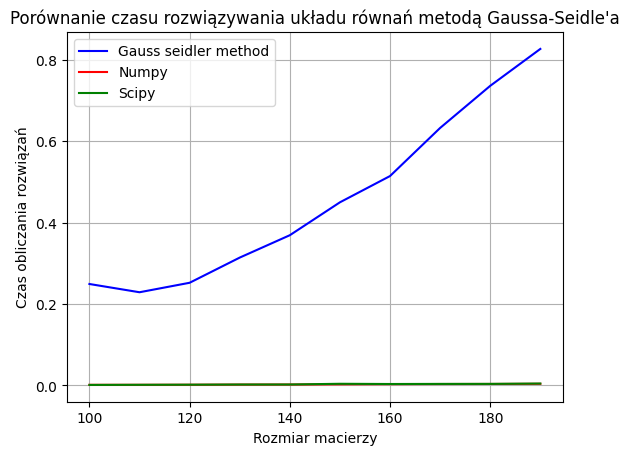

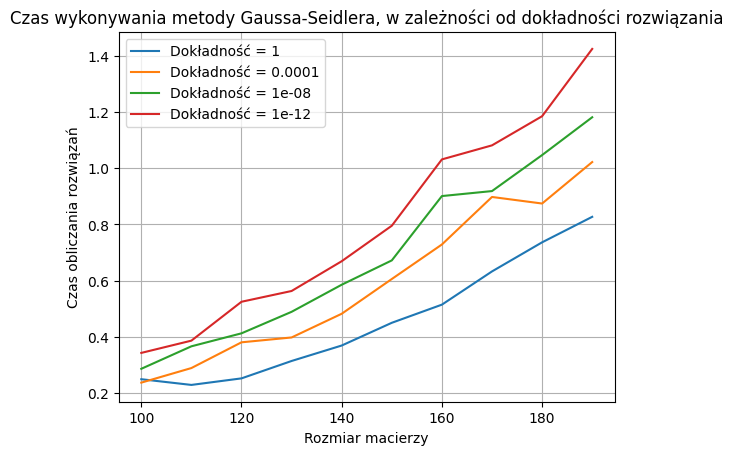

In [207]:
a = 10
m = 10
n_lst = [10 * i for i in range(a, a + m)]
accuracy = [10 ** (-i * 4) for i in range(4)]
t_np = np.zeros(m)
t_sp = np.zeros(m)
t_gs = {a: np.zeros(m) for a in accuracy}

for i, n in enumerate(n_lst):
    A = create_matrix_to_ex_2(n)
    b = create_vector_to_ex_2(n)
    t_np[i] = measure_solving_time((A, b), np.linalg.solve)
    t_sp[i] = measure_solving_time((A, b), scipy.linalg.solve)

    for acc in accuracy:
        t_gs[acc][i] = measure_solving_time((A, b, acc), gauss_seidle_method)

plt.plot(n_lst, t_gs[accuracy[0]], label=f'Gauss seidler method (dokładność do {accuracy[0]}', color='blue')
plt.plot(n_lst, t_np, label='Numpy', color='red')
plt.plot(n_lst, t_sp, label='Scipy', color='green')
plt.title("Porównanie czasu rozwiązywania układu równań metodą Gaussa-Seidle'a")
plt.xlabel('Rozmiar macierzy')
plt.ylabel('Czas obliczania rozwiązań')
plt.grid(True)
plt.legend()
plt.show()

for acc in accuracy:
    plt.plot(n_lst, t_gs[acc], label=f'Dokładność = {acc}')
plt.title("Czas wykonywania metody Gaussa-Seidlera, w zależności od dokładności rozwiązania")
plt.grid()
plt.xlabel('Rozmiar macierzy')
plt.ylabel('Czas obliczania rozwiązań')
plt.legend()
plt.show()

Zauważmy, że metoda Gaussa-Seidla działa znacznie wolniej w porównaniu z wbudowanymi metodami dostępnymi w bibliotekach numpy i scipy. Jest to spowodowane koniecznością obliczania macierzy odwrotnej oraz wielokrotnego mnożenia macierzy przez wektor w trakcie obliczeń. Dodatkowo, jak wynika z drugiego wykresu, czas działania tej metody wydłuża się wraz ze wzrostem wymagań co do precyzji rozwiązania układu równań – im większa dokładność, tym dłuższy czas obliczeń.

### Zadanie 4

In [10]:
def create_matrix_to_ex_4():
    B = np.zeros((20, 20))
    for i in range(19):
        B[i][i] = 0.025 * (i + 1)
        B[i][i + 1] = 5.0
    B[19][19] = 0.025 * 20
    return B


def norm_2(x):
    return np.sqrt(np.sum(np.power(x, 2)))


def find_min_k(norm2_lst):
    for i in range(len(norm2_lst)):
        if norm2_lst[i] < 1:
            return i

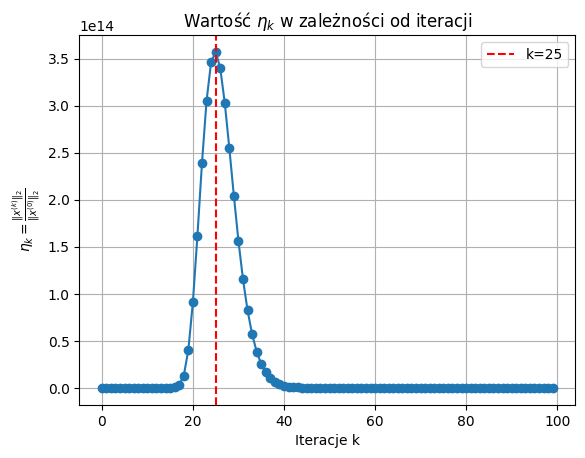

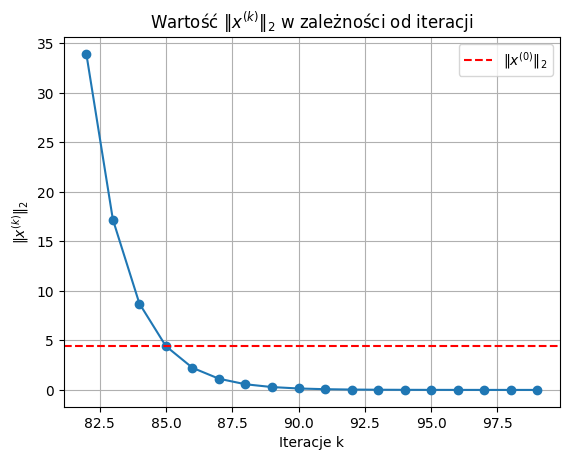

Wartość normy x_k jest mniejsza od wartości normy x_0 dla k = 85


In [34]:
B = create_matrix_to_ex_4()
x_k = np.array([1.0 for _ in range(20)])
x_0_norm = norm_2(x_k)

k = 100
norm2_x_k_lst = np.zeros(k)
norm2_x_k_divided_by_norm2_x_0 = np.zeros(k)
x_k = B @ x_k
for i in range(1, k+1):
    norm2_x_k = norm_2(x_k)
    norm2_x_k_lst[i-1] = norm2_x_k
    norm2_x_k_divided_by_norm2_x_0[i-1] = norm2_x_k / x_0_norm
    x_k = B @ x_k

plt.plot(np.arange(k), norm2_x_k_divided_by_norm2_x_0, marker='o')
plt.axvline(x=25, linestyle='--', color='red', label=f'k=25')
plt.xlabel("Iteracje k")
plt.ylabel(r"$\eta_k = \frac{\|x^{(k)}\|_2}{\|x^{(0)}\|_2}$")
plt.title("Wartość $\eta_k$ w zależności od iteracji")
plt.legend(loc='best')
plt.grid()
plt.show()


plt.plot(np.arange(82, k, 1), norm2_x_k_lst[82:], marker='o')
plt.axhline(y=x_0_norm, linestyle='--', color='red', label=r'$\|x^{(0)}\|_2$')
plt.xlabel("Iteracje k")
plt.ylabel(r"$\|x^{(k)}\|_2$")
plt.title("Wartość $\|x^{(k)}\|_2$ w zależności od iteracji")
plt.grid()
plt.legend(loc='best')
plt.show()

print(r'Wartość normy x_k jest mniejsza od wartości normy x_0 dla k =', find_min_k(norm2_x_k_divided_by_norm2_x_0))